# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes =  len(np.unique(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


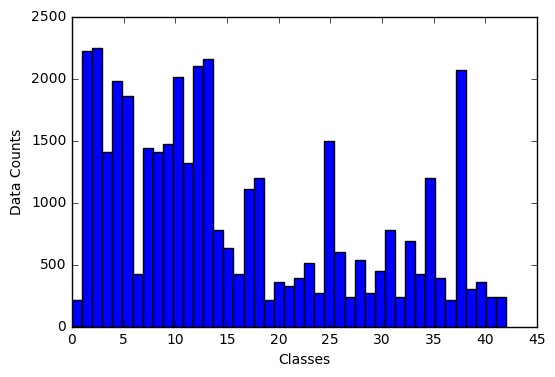

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline
import matplotlib.pyplot as plt

# Histogram to explore the balance of training data
plt.hist(y_train, bins = n_classes)
plt.xlabel('Classes')
plt.ylabel('Data Counts')
plt.show();

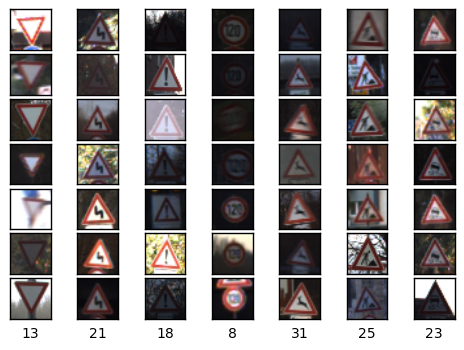

In [5]:
import random

def plot_images(image, label, label_number, image_number):
    sample_classes = random.sample(range(min(y_train), max(y_train) + 1), label_number)
    fig, axes = plt.subplots(label_number, image_number)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        cls = sample_classes[i%label_number]
        img_ind = random.choice(np.where(y_train == cls)[0])
        ax.imshow(image[img_ind]);
        ax.set_xlabel(str(cls))
        ax.set_xticks([])
        ax.set_yticks([])

# Show 7 pictures from 7 random classes
plot_images(X_train, y_train, 7, 7)

# Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import LabelBinarizer

# Implement Min-Max scaling for the image data
# Or use MinMaxScaler() from Scikit-learn
def normalize_img(img):
    x_min = 0
    x_max = 255
    a = -1.0
    b = 1.0
    return a + (img - x_min) * (b - a) / (x_max - x_min)

X_train = normalize_img(X_train)  
X_test = normalize_img(X_test)

# Implement one-hot encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1. For the features, I used normailization to keep the image pixel values between -1.0 and 1.0
2. For the labels, I used one-hot encoding.

In [7]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size = 0.2, 
                                                      random_state = 12345)

print("trainning data size: %d, validation data size: %d" %(X_train.shape[0], X_valid.shape[0]))

trainning data size: 31367, validation data size: 7842


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I used scikit-learn's train_test_split function to split training data to training and validation data with a ratio of 5 to 1. "Random_state" is set to a hard-coded number to always generate the same ramdom state. This helps me to better evalute performance of the neural network over changes.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

# Input image size
image_size = X_train[0].shape[0]
num_channels = X_train[0].shape[2]

# Filter size
patch_size = 5
depth = 16
num_hidden = 256

graph = tf.Graph()
with graph.as_default():
    features = tf.placeholder(tf.float32, [None, image_size, image_size, num_channels])
    labels = tf.placeholder(tf.float32, [None, n_classes])
    keep_prob = tf.placeholder(tf.float32)
    
    weights =  {
        'layer1': tf.Variable(tf.truncated_normal(shape = [patch_size, patch_size, num_channels, depth], 
                                                  stddev = 0.1)),
        'layer2': tf.Variable(tf.truncated_normal(shape = [patch_size, patch_size, depth, depth], 
                                                  stddev = 0.1)),
        'layer3': tf.Variable(tf.truncated_normal(shape = [image_size // 4 * image_size // 4 * depth, num_hidden], 
                                                  stddev = 0.1)),
        'layer4': tf.Variable(tf.truncated_normal(shape = [num_hidden, n_classes], stddev = 0.1))
    }
    biases = {
        'layer1': tf.Variable(tf.zeros([depth])),
        'layer2': tf.Variable(tf.zeros([depth])),
        'layer3': tf.Variable(tf.zeros([num_hidden])),
        'layer4': tf.Variable(tf.zeros([n_classes]))
    }
    
    # Layer 1
    conv = tf.nn.conv2d(features, weights['layer1'], [1, 1, 1, 1], padding = 'SAME')
    hidden = tf.nn.relu(conv + biases['layer1'])
    pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    # Layer 2
    conv = tf.nn.conv2d(pool, weights['layer2'], [1, 1, 1, 1], padding = 'SAME')
    hidden = tf.nn.relu(conv + biases['layer2'])
    pool = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # Layer 3
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, shape = [-1, shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
    hidden = tf.nn.dropout(hidden, keep_prob)
    
    # Layer 4
    logits = tf.matmul(hidden, weights['layer4']) + biases['layer4']
    
    # Regulation
    regul = 0.01 * (tf.nn.l2_loss(weights['layer1']) + 
                    tf.nn.l2_loss(weights['layer2']) +
                    tf.nn.l2_loss(weights['layer3']) +
                    tf.nn.l2_loss(weights['layer4']))
    # Optimizaer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels) + regul)
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.
epoches = 15
batch_size = 128
train_data_size = X_train.shape[0]

feed_dict_valid = {features: X_valid, labels: y_valid, keep_prob: 1.0}
feed_dict_test = {features: X_test, labels: y_test, keep_prob: 1.0}

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    for epoch in range(1, epoches + 1):
        # Shuffle the indices for the trainning data
        ind = np.arange(0, train_data_size)
        np.random.shuffle(ind)
        X_train_shuffle = X_train[ind]
        y_train_shuffle = y_train[ind]
        for batch_ind in range(0, train_data_size, batch_size):
            batch_data = X_train_shuffle[batch_ind : (batch_ind + batch_size), :, :, :]
            batch_labels = y_train_shuffle[batch_ind : (batch_ind + batch_size), :]
            feed_dict_train = {features: batch_data, labels: batch_labels, keep_prob: 0.5}
            _, l, acc = session.run([optimizer, loss, accuracy], feed_dict = feed_dict_train)
        print("epoch: %d\tloss: %f\taccuracy: %f" % (epoch, l, acc))
        print("Validation accuracy:\t%f" %accuracy.eval(feed_dict = feed_dict_valid))
    print("Test accuracy:\t%f" %accuracy.eval(feed_dict = feed_dict_test))

epoch: 1	loss: 11.380940	accuracy: 0.142857
Validation accuracy:	0.348763
epoch: 2	loss: 7.733218	accuracy: 0.714286
Validation accuracy:	0.618720
epoch: 3	loss: 6.206367	accuracy: 0.857143
Validation accuracy:	0.738842
epoch: 4	loss: 4.426538	accuracy: 1.000000
Validation accuracy:	0.912650
epoch: 5	loss: 4.107432	accuracy: 0.857143
Validation accuracy:	0.876690
epoch: 6	loss: 3.288401	accuracy: 0.857143
Validation accuracy:	0.808212
epoch: 7	loss: 2.739049	accuracy: 0.857143
Validation accuracy:	0.831931
epoch: 8	loss: 2.054785	accuracy: 1.000000
Validation accuracy:	0.938409
epoch: 9	loss: 1.818755	accuracy: 1.000000
Validation accuracy:	0.913925
epoch: 10	loss: 1.633926	accuracy: 0.857143
Validation accuracy:	0.887529
epoch: 11	loss: 1.271204	accuracy: 1.000000
Validation accuracy:	0.942489
epoch: 12	loss: 1.635545	accuracy: 0.857143
Validation accuracy:	0.653277
epoch: 13	loss: 0.934121	accuracy: 1.000000
Validation accuracy:	0.967100
epoch: 14	loss: 0.941940	accuracy: 1.000000
Va

In [59]:
### Train your model here.
### Feel free to use as many code cells as needed.
epoches = 5
batch_size = 128

feed_dict_valid = {features: X_valid, labels: y_valid, keep_prob: 1.0}
feed_dict_test = {features: X_test, labels: y_test, keep_prob: 1.0}

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps + 1):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict_train = {features: batch_data, labels: batch_labels, keep_prob: 0.5}
        _, l, acc = session.run([optimizer, loss, accuracy], feed_dict = feed_dict_train)
        if (step % 100 == 0):
            print("step: %d,\tloss: %.3f,\taccuracy: %.5f" % (step, l, acc))
    print("Validation accuracy: %.5f" %accuracy.eval(feed_dict = feed_dict_valid))
    print("Test accuracy: %.5f" %accuracy.eval(feed_dict = feed_dict_test))

step: 0,	loss: 16.274,	accuracy: 0.00000
step: 100,	loss: 12.734,	accuracy: 0.24219
step: 200,	loss: 11.081,	accuracy: 0.40625
step: 300,	loss: 9.671,	accuracy: 0.54688
step: 400,	loss: 8.722,	accuracy: 0.63281
step: 500,	loss: 8.028,	accuracy: 0.57031
step: 600,	loss: 7.090,	accuracy: 0.69531
step: 700,	loss: 6.201,	accuracy: 0.83594
step: 800,	loss: 5.855,	accuracy: 0.82031
step: 900,	loss: 5.431,	accuracy: 0.77344
step: 1000,	loss: 4.877,	accuracy: 0.81250
step: 1100,	loss: 4.453,	accuracy: 0.82031
step: 1200,	loss: 4.137,	accuracy: 0.85156
step: 1300,	loss: 3.797,	accuracy: 0.84375
step: 1400,	loss: 3.590,	accuracy: 0.85938
step: 1500,	loss: 3.145,	accuracy: 0.93750
step: 1600,	loss: 2.964,	accuracy: 0.91406
step: 1700,	loss: 2.742,	accuracy: 0.91406
step: 1800,	loss: 2.491,	accuracy: 0.93750
step: 1900,	loss: 2.252,	accuracy: 0.94531
step: 2000,	loss: 2.172,	accuracy: 0.93750
Validation accuracy: 0.95626
Test accuracy: 0.88725


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.